### TO-DO
- <strike>CV Error plots</strike>
- <strike>Zero centering of data</strike>
- <strike>L1/L2 regularization</strike>
- <strike>Xavier initialization (to avoid dead neurons in Sigmoids/Tanh)</strike>
- <strike>He et.al initiliazation (to avoid dead neurons in ReLUs)</strike>
- <strike>Momentum/Nesterov Momentum</strike>
- Adam
- Benchmark current Algorithm on CIFAR - 10 dataset
- Dropout (Inverted Dropout)
- Batch Norm
- HyperOpt
- Convolution Layers

In [1]:
import numpy as np
import random as rd
from matplotlib import pyplot as plt
from mnist import MNIST as mn
import time
from PIL import Image

%matplotlib inline

In [2]:
def centerData2(inputMatrix):
    
    """Center each variable to 0"""
    # (x - mu)/sigma. Data is now centered at 0
    
    # Calculate mean and variance for each input feature
    variableMeans = np.mean(inputMatrix, axis = 0)
    
    # Centering with mean and return
    centerData = inputMatrix - variableMeans
    return centerData,variableMeans

In [3]:
# Lookup table of activation functions and derivatives
actLookup = {"sigmoid":lambda x: 1/(1 + np.exp(-1 * x)),
             "tanh":lambda x: np.tanh(x),
            "relu": lambda x: np.maximum(0,x)}

derivativeLookup = {"sigmoid": lambda x: x * (1.-x),
               "tanh": lambda x: 1. - (np.tanh(x) ** 2),
              "relu": lambda x: np.ceil(x.clip(0,1))}

# Weight Initialization strategy
# Random multiplies the initializations by a small number
# Xavier 1/sqrt(numInputs)
# For relu's, initalization is as recommended by He et. al(2015)
weightLookup = {"random":lambda x:0.01,
               "xavier":lambda x:1/sqrt(x),
               "he.et.al":lambda x:2/np.sqrt(x)}

# Regularization error component,
# 0 if none, sum(x^2) if L2 and sum(|x|) if L1
regLookup = {"none":lambda x: 0,
            "l2": lambda x: 0.5 * (x ** 2).sum(),
            "l1" : lambda x:sum(abs(x))}

# Derivatives of regularization terms
regDerivLookup = {"none": lambda x:0,
                "l2": lambda x: x,
                "l1": lambda x: 1}

# Momentum rate update
momentumLookup = {"none":0,
                  "momentum":lambda x:1,
                  "nag": lambda x: (1+x)}

In [66]:
class layer(object):
    # A neural net layer with n neurons as defined by the user and an activation function for the layer
    
    def __init__(self,numInputs, layerSize, actFun = "sigmoid", weightInit = "random"):
    
        # Size of the layer and the number of inputs
        self.layerSize = layerSize
        self.actFun = actLookup[actFun]
        self.deriv = derivativeLookup[actFun]

        # Incorporating the bias neuron
        self.numInputs = numInputs + 1
        self.inputMatrix = None
        
        # Numpy matrix of weights
        np.random.seed(seed=10000)
        self.weights = np.array(np.random.randn(self.layerSize,self.numInputs))/100 * \
        weightLookup[weightInit](self.numInputs)
        
        # Set the backward propagation values for this layer
        self.delta = None
        
        # Various components of learning methods (Momentum/NAG)
        self.velocity = np.zeros(self.weights.shape)
        self.vPrev = self.velocity
        self.m = np.zeros(self.weights.shape)
               
        
    # Defining the forward function to the layer
    def forward(self, inputMatrix):
        """Forward() forward propagates the inputs to a layer"""
        
        # Convert to numpy array if not passed as a numpy array
        if(not(isinstance(inputMatrix,np.ndarray))):
            inputMatrix = np.array(inputMatrix)
        
        rows, columns = inputMatrix.shape
        
        # Dot product of input matrix (with extra 1s for the bias neuron) with the weight matrix
        inputPadded = np.append(np.ones(rows).reshape(rows,1), inputMatrix, axis = 1)
        self.inputMatrix = inputPadded
        layerOutput = np.dot(inputPadded, self.weights.T)
        
        # Pass through activation function
        self.output = self.actFun(layerOutput)
        return self.output
    
    # Defining the backward propagation function
    def backward(self, delta):
        """Backward takes the delta from next layer and passes it on the previous layer"""        

        # Delta passed back is wkh * deltak for every batch instance
        # Delta for each batch element is sum by column of the delta matrix passed back
        # by the next layer

        self.delta = np.multiply(self.deriv(self.output),delta)
        
        # Delta to pass on to preceding layer has to be 
        # matrix multiplication of these values by the weight matrix
        weightMatrix = self.weights[:,1:]
        
        # deltaBack = weightMatrix.T.dot(self.delta.T)
        deltaBack = self.delta.dot(weightMatrix)
        return deltaBack
    
    def updateWeights(self, learnRate,
                      regularize = "none", lambdaReg = 0.01,
                      learningMethod = "none", mu = 0.9,
                      adam = 0, beta1 = 0.9, beta2 = 0.999, eps = 1e-8, t = 1):
        """updateWeights() uses the inputs and the delta stored in each layer after forward
        and backward propagation to derive the weight update rule"""
        
        regDeriv = regDerivLookup[regularize]
        # The udpate rule for eachelement in the matrix is given by
        # wi = wi + sum_over_instances(delta for neuron * input i to neuron * learning rated)
        # Compute the weight updates for every data point and then add those updates
        rows,columns = self.inputMatrix.shape
        stepGradient = -1. * np.dot(self.inputMatrix.T,self.delta).T * (1/np.float(rows))
        
        # Regularization if applicable
        stepGradient = np.add(stepGradient, lambdaReg * regDeriv(self.weights))
        
        # Weight updates for adam
        self.m = beta1 * np.float(adam) * self.m \
        + ((1. - beta1) * adam + (1. - adam) * (-learnRate)) * stepGradient
        
        weightUpdates = self.m
                
        # Different learning methods
        self.vPrev = self.velocity
    
        # Momentum using adam
        self.velocity = (beta2 * adam + (1.-adam) * mu) * self.velocity \
        + (1. - beta2) * adam * (stepGradient ** 2) \
        + (1. - adam) * weightUpdates

        # Change weightUpdates based on the learning rate
        weightUpdates = (1. - adam) * \
        np.add(weightUpdates, momentumLookup[learningMethod](mu)  * self.velocity)
        
        # If NAG is chosen, additional term gets added
        weightUpdates = (1. - adam) * \
        np.subtract(weightUpdates, (mu if learningMethod == "nag" else 0.) * self.vPrev)
        
        # Bias correction for Adam
        self.m = self.m/(1. - beta1 ** t)
        self.velocity = self.velocity * ((1 - adam) + adam * (1./(1. - beta2 ** t)))
    
        
        # If adam update is chosen
        adamUpdate = -adam * learnRate * self.m / (np.sqrt(np.float(adam) * self.velocity) + eps)
                
        
        # Final Weight updates
        self.weights = np.add(self.weights, np.float(adam) * adamUpdate + (1. - adam) * weightUpdates)

In [67]:
class neuralNet(object):
    
    """Neural net object is a combination of layer objects. Has 2 functions
    predict and backprop"""
    


    def __init__(self, layerList, actFun = "sigmoid", weightInit = "random"):
        
        """Takes in the layerlist as input and generates as many layers"""
        
        self.actFun = actFun
        
        # Creating the layers
        self.layers = [layer(numInputs=layerList[i - 1],
                             layerSize=layerList[i],                            
                             actFun=self.actFun,
                            weightInit = weightInit) for i in range(1, len(layerList))]
        self.cvError = None
        self.regLoss= None
        
    def predict(self, inputMatrix):
        """Predict function is used to propagate the inputs from 
        one layer to the next and get the final output from the layer"""
        # Pass on input of previous layer to the next
        # If 1st hidden layer, pass on the input
        layerOut = inputMatrix
        
        for layer in self.layers:
            layerOut = layer.forward(inputMatrix=layerOut)
            
        return layerOut
    
    def computeError(self, inputs, outputs):
        
        predictions = self.predict(inputs)
        numRows = inputs.shape[0]
        # Calculate deltas and sum squares
        delta = np.subtract(predictions,outputs)
        totalError = np.sum(delta**2)/numRows
        return totalError
    
    def computeRegularizationLoss(self, regularize, lambdaReg):
        # Calculate layerWise sums and get total
        regLossFunction  = regLookup[regularize]       
        layerRegs = np.array([lambdaReg * regLossFunction(layer.weights) for layer in self.layers])
        return(layerRegs.sum())
    
    def backprop(self, trainInput, trainOutput, learnRate, 
                 testInput,testOutput,
                 batchSize = 1, nIter = 100, 
                 showStep = 1000, stepError = 1000,
                 regularize = "none",lambdaReg = 0.01,
                 learningMethod = "none", mu = 0.9,
                 adam = 0, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        
        """Back prop is used to update the 2000weights based on the training sample
        It runs nIter iterations on the trainInput with batchSize number of rows
        Weight updates are carried out at learning rate learnRate"""
        
        if(not(isinstance(trainOutput,np.ndarray))):
            trainOutput = np.array(trainOutput)
        if(not(isinstance(trainInput,np.ndarray))):
            trainInput = np.array(trainInput)
        
        rows, columns = trainInput.shape
        
        # initialize empty CV error matrix: Column 1 represents Train Error
        # Column 2 represents Test Error
        self.cvError = np.zeros(nIter/stepError * 2).reshape(nIter/stepError,2)
        
        self.regLoss = np.zeros(nIter/stepError * 2).reshape(nIter/stepError,2)
        
        for i in range(nIter):
            
            if((i + 1) % showStep == 0):
                print i + 1
                
            if((i + 1) % stepError == 0):
                self.cvError[((i + 1) / stepError)-1] = [self.computeError(trainInput,trainOutput),
                                   self.computeError(testInput,testOutput)]
                
                self.regLoss[((i + 1) / stepError)-1] = [self.computeRegularizationLoss(regularize = regularize,
                                                                                        lambdaReg = lambdaReg)]
            
            # Pick a random sample from the trainInput and trainOutput
            # Updated weights based on the same. Sample size is to be of size batchSize
            
            randomIndices = np.random.choice(range(rows),size=batchSize)
            
            # Sample from trainInput and trainOutput
            batchTrain = trainInput[randomIndices,:].reshape(batchSize,columns)
            batchTest = trainOutput[randomIndices,:]
        
            # A forward pass through the network
            output = self.predict(batchTrain)
            
            # Iterate backwards through the layers to pass the deltas
            delta = np.subtract(batchTest,output)
            
            for layer in self.layers[::-1]:
                
                # Delta to be passed to the previous layer is computed
                delta = layer.backward(delta=delta)
                # Update weights as determined by the delta gradient
                layer.updateWeights(learnRate=learnRate, 
                                    regularize = regularize, lambdaReg = lambdaReg,
                                    learningMethod = learningMethod, mu = mu,
                                    adam = adam, beta1 = beta1, beta2 = beta2, eps = eps, t = i + 1)

In [7]:
mdata = mn(path='../datasets/MNIST/')

In [8]:
images,labels = mdata.load_training()
images = np.array(images)/255.
labels = np.array(labels).reshape(60000,1).astype(dtype = 'uint8')
labels = np.unpackbits(labels,axis=1)
labels = labels[:,4:8]

In [9]:
sampleIndices = np.random.choice(range(len(images)),size=10000)

In [10]:
imageTrain = images[sampleIndices]

In [11]:
labelTrain = labels[sampleIndices]

In [12]:
testImages,testLabels = mdata.load_testing()
testImages = np.array(testImages)/255.
testLabelsDigit = np.array(testLabels).reshape(10000,1).astype(dtype = 'uint8')
testLabels = np.unpackbits(testLabelsDigit,axis=1)
testLabels = testLabels[:,4:8]

In [13]:
sampleTestIndices = np.random.choice(range(len(testImages)), 2000)

In [15]:
imageTest = testImages[sampleTestIndices]

In [16]:
labelTestDigit = testLabelsDigit[sampleTestIndices]
labelTest = testLabels[sampleTestIndices]

In [17]:
# Not improving accuracy
# centerTrain, trainMeans = centerData2(imageTrain)
# centerTest = imageTest - trainMeans

In [92]:
# Training a neural net with 256 inputs, 300 hidden units (1 layer only)
nn3 = neuralNet(layerList=[784,300,4],actFun="relu",weightInit="he.et.al")

In [93]:
nn3.backprop(batchSize=5,learnRate=0.01,nIter=50000,showStep=5000,stepError=40,
             trainOutput=labelTrain,testOutput=labelTest,trainInput=imageTrain,testInput=imageTest,
             learningMethod="nag",mu=0.9,adam = 0)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [94]:
# Compute accuracy of digit recognition
preds = nn3.predict(imageTest)
preds = np.array([np.round(arr) for arr in preds])
preds = np.append(np.zeros(8000).reshape(2000,4),preds,axis=1)
predDigits = np.packbits(preds.astype("bool"))
acc = [predDigits[i] == labelTestDigit[i] for i in range(2000)]
print sum(acc)/2000.

[ 0.948]


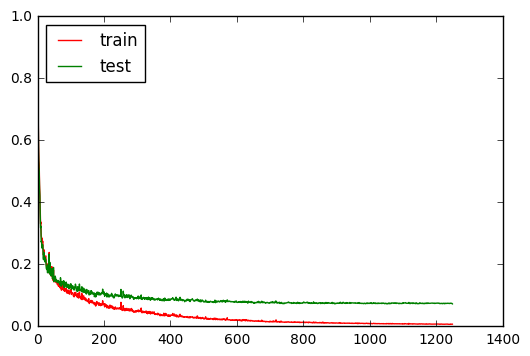

In [95]:
plt.plot(nn3.cvError[:,0],'r',label = 'train')
plt.plot(nn3.cvError[:,1],'g',label = 'test')
plt.legend(loc = 'upper left')
plt.show()